# Data Mining Lab 2: Report for the Kaggle competition
Emotion recognition on twitter

# Student Information

Name: Virintorn Kantaravichaiwat (陳琳珊）

Student ID: 110065427

GitHub ID: sandvirin

Kaggle name: sandvirin

Kaggle private scoreboard snapshot: 
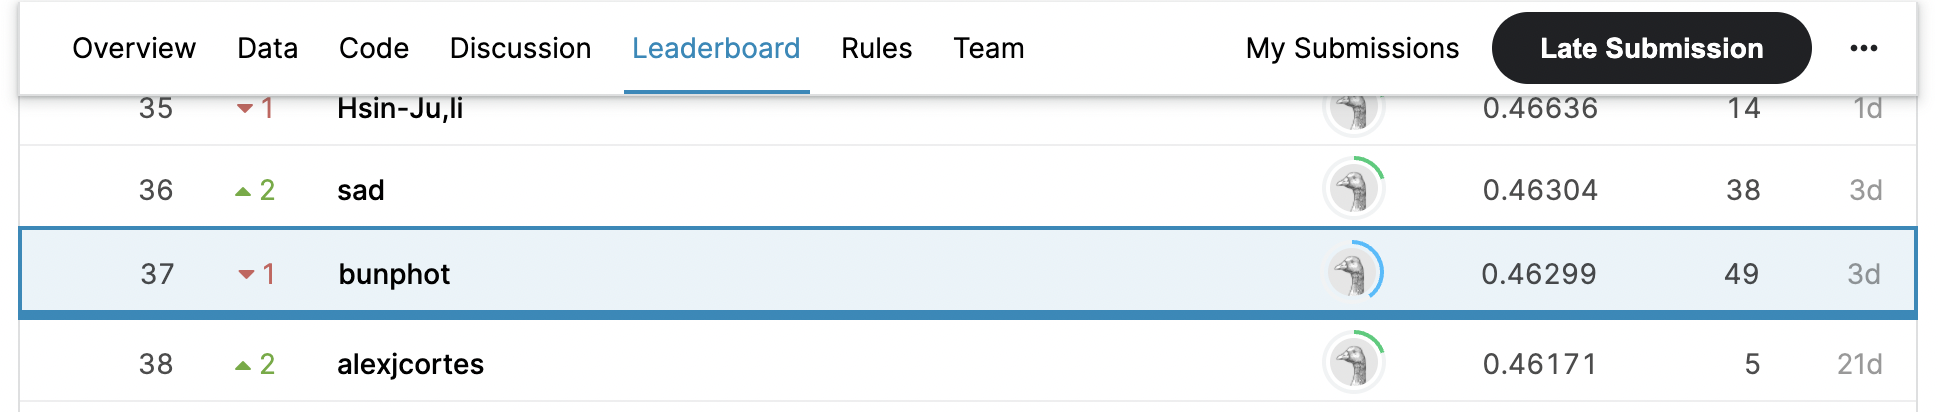

## Table of Contents
1. Data preparation
2. Feature engineering
3. Model
4. Results evaluation
5. Conclusion

---
# 1. Data Preparation

The dataset is crawled from Twitter with labeled the emotion for these tweets by some specific hashtags in the original text. There are 8 classes (or say emotions) in our dataset: anger, anticipation, disgust, fear, sadness, surprise, trust, and joy.

## 1.1 Import and Merge Data

Load Data from .csv/.json files

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, callbacks
from tensorflow.keras import Model, Sequential

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import re, itertools
import string

import nltk
nltk.download("stopwords")

import sys
import os
import nltk
nltk.download('punkt')
import csv
import datetime
from bs4 import BeautifulSoup
import re
import itertools
import emoji

[nltk_data] Downloading package stopwords to /Users/sand/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sand/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#import data
tweets = pd.read_json("data/tweets_DM.json",lines=True)

In [3]:
#check
tweets

,_score,_index,_source,_crawldate,_type
0,391,hashtag_tweets,"{'tweet': {'hashtags': ['Snapchat'], 'tweet_id...",2015-05-23 11:42:47,tweets
1,433,hashtag_tweets,"{'tweet': {'hashtags': ['freepress', 'TrumpLeg...",2016-01-28 04:52:09,tweets
2,232,hashtag_tweets,"{'tweet': {'hashtags': ['bibleverse'], 'tweet_...",2017-12-25 04:39:20,tweets
3,376,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x1cd5...",2016-01-24 23:53:05,tweets
4,989,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2de2...",2016-01-08 17:18:59,tweets
...,...,...,...,...,...
1867530,827,hashtag_tweets,"{'tweet': {'hashtags': ['mixedfeeling', 'butim...",2015-05-12 12:51:52,tweets
1867531,368,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x29d0...",2017-10-02 17:54:04,tweets
1867532,498,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2a6a...",2016-10-10 11:04:32,tweets
1867533,840,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x24fa...",2016-09-02 14:25:06,tweets


In [4]:
#normalize json data
data = tweets['_source'].tolist()
df = pd.DataFrame.from_dict(pd.json_normalize(data), orient='columns')
tweets= pd.concat([tweets, df], axis=1)

In [5]:
ident = pd.read_csv("data/data_identification.csv")
emotion = pd.read_csv("data/emotion.csv")

In [6]:
#drop col _source
tweets.drop('_source', axis='columns', inplace=True)

In [7]:
#rename col.
tweets = tweets.rename(columns = {'tweet.hashtags':'hashtags','tweet.tweet_id':'tweet_id','tweet.text':'text'} )
#check
tweets

,_score,_index,_crawldate,_type,hashtags,tweet_id,text
0,391,hashtag_tweets,2015-05-23 11:42:47,tweets,[Snapchat],0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,433,hashtag_tweets,2016-01-28 04:52:09,tweets,"[freepress, TrumpLegacy, CNN]",0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,232,hashtag_tweets,2017-12-25 04:39:20,tweets,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k..."
3,376,hashtag_tweets,2016-01-24 23:53:05,tweets,[],0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,989,hashtag_tweets,2016-01-08 17:18:59,tweets,[],0x2de201,"""Trust is not the same as faith. A friend is s..."
...,...,...,...,...,...,...,...
1867530,827,hashtag_tweets,2015-05-12 12:51:52,tweets,"[mixedfeeling, butimTHATperson]",0x316b80,When you buy the last 2 tickets remaining for ...
1867531,368,hashtag_tweets,2017-10-02 17:54:04,tweets,[],0x29d0cb,I swear all this hard work gone pay off one da...
1867532,498,hashtag_tweets,2016-10-10 11:04:32,tweets,[],0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...
1867533,840,hashtag_tweets,2016-09-02 14:25:06,tweets,[],0x24faed,"Ah, corporate life, where you can date <LH> us..."


In [8]:
#compress size for saving memory space
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% Compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
def resumetable(df):
    print(f'Shape : {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['Data Type'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': 'Feature'})
    summary['Num of null'] = df.isnull().sum().values
    summary['Num of unique'] = df.nunique().values
    summary['First value'] = df.loc[0].values
    summary['Second value'] = df.loc[1].values
    summary['Third value'] = df.loc[2].values
    return summary

In [9]:
tweets = downcast(tweets)
ident = downcast(ident)
emotion = downcast(emotion)

10.7% Compressed
0.0% Compressed
0.0% Compressed


In [10]:
#merge
data=pd.merge(ident,emotion,on='tweet_id',how='left')

In [11]:
data=pd.merge(data,tweets,on='tweet_id',how='left')

In [12]:
#rename col.
data = data.rename(columns = {'tweet_id':'id'} )
#check
data

,id,identification,emotion,_score,_index,_crawldate,_type,hashtags,text
0,0x28cc61,test,NaN,107,hashtag_tweets,2017-01-17 14:13:32,tweets,[],@Habbo I've seen two separate colours of the e...
1,0x29e452,train,joy,809,hashtag_tweets,2015-01-17 03:07:03,tweets,[],Huge Respect🖒 @JohnnyVegasReal talking about l...
2,0x2b3819,train,joy,808,hashtag_tweets,2016-07-02 09:34:06,tweets,"[spateradio, app]",Yoooo we hit all our monthly goals with the ne...
3,0x2db41f,test,NaN,728,hashtag_tweets,2015-10-17 06:46:20,tweets,[],@FoxNews @KellyannePolls No serious self respe...
4,0x2a2acc,train,trust,16,hashtag_tweets,2016-08-15 18:18:39,tweets,[],@KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...
...,...,...,...,...,...,...,...,...,...
1867530,0x227e25,train,disgust,361,hashtag_tweets,2016-09-09 14:28:19,tweets,[rip],@BBCBreaking Such an inspirational talented pe...
1867531,0x293813,train,sadness,15,hashtag_tweets,2017-02-04 14:15:32,tweets,"[libtards, Hillary, lost, sad, growup, Trump]",And still #libtards won't get off the guy's ba...
1867532,0x1e1a7e,train,joy,174,hashtag_tweets,2015-12-03 16:53:39,tweets,"[seeds, Joy, GLTChurch]",When you sow #seeds of service or hospitality ...
1867533,0x2156a5,train,trust,515,hashtag_tweets,2016-10-27 03:23:51,tweets,[],@lorettalrose Will you be displaying some <LH>...


In [13]:
#split train
train_df = data.loc[data['identification']=='train']
#check
train_df

,id,identification,emotion,_score,_index,_crawldate,_type,hashtags,text
1,0x29e452,train,joy,809,hashtag_tweets,2015-01-17 03:07:03,tweets,[],Huge Respect🖒 @JohnnyVegasReal talking about l...
2,0x2b3819,train,joy,808,hashtag_tweets,2016-07-02 09:34:06,tweets,"[spateradio, app]",Yoooo we hit all our monthly goals with the ne...
4,0x2a2acc,train,trust,16,hashtag_tweets,2016-08-15 18:18:39,tweets,[],@KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...
5,0x2a8830,train,joy,768,hashtag_tweets,2017-02-11 08:49:46,tweets,"[PUBG, GamersUnite, twitch, BeHealthy, StayPos...",Come join @ambushman27 on #PUBG while he striv...
6,0x20b21d,train,anticipation,70,hashtag_tweets,2016-11-23 05:37:10,tweets,"[strength, bones, God]",@fanshixieen2014 Blessings!My #strength little...
...,...,...,...,...,...,...,...,...,...
1867530,0x227e25,train,disgust,361,hashtag_tweets,2016-09-09 14:28:19,tweets,[rip],@BBCBreaking Such an inspirational talented pe...
1867531,0x293813,train,sadness,15,hashtag_tweets,2017-02-04 14:15:32,tweets,"[libtards, Hillary, lost, sad, growup, Trump]",And still #libtards won't get off the guy's ba...
1867532,0x1e1a7e,train,joy,174,hashtag_tweets,2015-12-03 16:53:39,tweets,"[seeds, Joy, GLTChurch]",When you sow #seeds of service or hospitality ...
1867533,0x2156a5,train,trust,515,hashtag_tweets,2016-10-27 03:23:51,tweets,[],@lorettalrose Will you be displaying some <LH>...


In [14]:
#spilt test
test_df = data.loc[data['identification']=='test']
#check
test_df

,id,identification,emotion,_score,_index,_crawldate,_type,hashtags,text
0,0x28cc61,test,NaN,107,hashtag_tweets,2017-01-17 14:13:32,tweets,[],@Habbo I've seen two separate colours of the e...
3,0x2db41f,test,NaN,728,hashtag_tweets,2015-10-17 06:46:20,tweets,[],@FoxNews @KellyannePolls No serious self respe...
15,0x2466f6,test,NaN,491,hashtag_tweets,2016-12-19 03:50:27,tweets,[womendrivers],"Looking for a new car, and it says 1 lady owne..."
23,0x23f9e9,test,NaN,28,hashtag_tweets,2017-04-09 19:32:19,tweets,[robbingmembers],@cineworld “only the brave” just out and fount...
31,0x1fb4e1,test,NaN,925,hashtag_tweets,2016-01-15 11:59:31,tweets,[],Felt like total dog 💩 going into open gym and ...
...,...,...,...,...,...,...,...,...,...
1867495,0x2c4dc2,test,NaN,792,hashtag_tweets,2017-04-01 02:52:58,tweets,[kids],6 year old walks in astounded. Mum! Look how b...
1867496,0x31be7c,test,NaN,34,hashtag_tweets,2016-11-13 07:34:17,tweets,[inspiringvolunteerawards2017],Only one week to go until the #inspiringvolunt...
1867500,0x1ca58e,test,NaN,976,hashtag_tweets,2017-10-26 19:12:59,tweets,[],"I just got caught up with the manga for ""My He..."
1867515,0x35c8ba,test,NaN,534,hashtag_tweets,2017-08-18 10:23:59,tweets,[],Speak only when spoken to and make hot ass mus...


In [15]:
# shuffle dataset
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [16]:
print("Shape of Training df: ", train_df.shape)
print("Shape of Testing df: ", test_df.shape)

Shape of Training df:  (1455563, 9)
Shape of Testing df:  (411972, 9)


Save to Pickle file (before cleaning)

In [17]:
## save to pickle file, more convenience, create pickle file = to_pickle
train_df.to_pickle("train_df.pkl")
test_df.to_pickle("test_df.pkl")

In [26]:
## load a pickle file, need to before opening = read_pickle
train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")

## 1.2 Cleaning Data

In [27]:
#function smile contraction
def load_dict_smileys():
    
    return {
        ":‑)":" smiley ",
        ":-]":" smiley ",
        ":-3":" smiley ",
        ":->":" smiley ",
        "8-)":" smiley ",
        ":-}":" smiley ",
        ":)":" smiley ",
        ":]":" smiley ",
        ":3":" smiley ",
        ":>":" smiley ",
        "8)":" smiley ",
        ":}":" smiley ",
        ":o)":" smiley ",
        ":c)":" smiley ",
        ":^)":" smiley ",
        "=]":" smiley ",
        "=)":" smiley ",
        ":-))":" smiley ",
        ":‑D":" smiley ",
        "8‑D":" smiley ",
        "x‑D":" smiley ",
        "X‑D":" smiley ",
        ":D":" smiley ",
        "8D":" smiley ",
        "xD":" smiley ",
        "XD":" smiley ",
        ":‑(":" sad ",
        ":‑c":" sad ",
        ":‑<":" sad ",
        ":‑[":" sad ",
        ":(":" sad ",
        ":c":" sad ",
        ":<":" sad ",
        ":[":" sad ",
        ":-||":" sad ",
        ">:[":" sad ",
        ":{":" sad ",
        ":@":" sad ",
        ">:(":" sad ",
        ":'‑(":" sad ",
        ":'(":" sad ",
        ":‑P":" playful ",
        "X‑P":" playful ",
        "x‑p":" playful ",
        ":‑p":" playful ",
        ":‑Þ":" playful ",
        ":‑þ":" playful ",
        ":‑b":" playful ",
        ":P":" playful ",
        "XP":" playful ",
        "xp":" playful ",
        ":p":" playful ",
        ":Þ":" playful ",
        ":þ":" playful ",
        ":b":" playful ",
        "<3":" love "
        }


def load_dict_contractions():
    
    return {
        "ain't":"is not",
        "amn't":"am not",
        "aren't":"are not",
        "can't":"cannot",
        "'cause":"because",
        "couldn't":"could not",
        "couldn't've":"could not have",
        "could've":"could have",
        "daren't":"dare not",
        "daresn't":"dare not",
        "dasn't":"dare not",
        "didn't":"did not",
        "doesn't":"does not",
        "don't":"do not",
        "e'er":"ever",
        "em":"them",
        "everyone's":"everyone is",
        "finna":"fixing to",
        "gimme":"give me",
        "gonna":"going to",
        "gon't":"go not",
        "gotta":"got to",
        "hadn't":"had not",
        "hasn't":"has not",
        "haven't":"have not",
        "he'd":"he would",
        "he'll":"he will",
        "he's":"he is",
        "he've":"he have",
        "how'd":"how would",
        "how'll":"how will",
        "how're":"how are",
        "how's":"how is",
        "I'd":"I would",
        "I'll":"I will",
        "I'm":"I am",
        "I'm'a":"I am about to",
        "I'm'o":"I am going to",
        "isn't":"is not",
        "it'd":"it would",
        "it'll":"it will",
        "it's":"it is",
        "I've":"I have",
        "kinda":"kind of",
        "let's":"let us",
        "mayn't":"may not",
        "may've":"may have",
        "mightn't":"might not",
        "might've":"might have",
        "mustn't":"must not",
        "mustn't've":"must not have",
        "must've":"must have",
        "needn't":"need not",
        "ne'er":"never",
        "o'":"of",
        "o'er":"over",
        "ol'":"old",
        "oughtn't":"ought not",
        "shalln't":"shall not",
        "shan't":"shall not",
        "she'd":"she would",
        "she'll":"she will",
        "she's":"she is",
        "shouldn't":"should not",
        "shouldn't've":"should not have",
        "should've":"should have",
        "somebody's":"somebody is",
        "someone's":"someone is",
        "something's":"something is",
        "that'd":"that would",
        "that'll":"that will",
        "that're":"that are",
        "that's":"that is",
        "there'd":"there would",
        "there'll":"there will",
        "there're":"there are",
        "there's":"there is",
        "these're":"these are",
        "they'd":"they would",
        "they'll":"they will",
        "they're":"they are",
        "they've":"they have",
        "this's":"this is",
        "those're":"those are",
        "'tis":"it is",
        "'twas":"it was",
        "wanna":"want to",
        "wasn't":"was not",
        "we'd":"we would",
        "we'd've":"we would have",
        "we'll":"we will",
        "we're":"we are",
        "weren't":"were not",
        "we've":"we have",
        "what'd":"what did",
        "what'll":"what will",
        "what're":"what are",
        "what's":"what is",
        "what've":"what have",
        "when's":"when is",
        "where'd":"where did",
        "where're":"where are",
        "where's":"where is",
        "where've":"where have",
        "which's":"which is",
        "who'd":"who would",
        "who'd've":"who would have",
        "who'll":"who will",
        "who're":"who are",
        "who's":"who is",
        "who've":"who have",
        "why'd":"why did",
        "why're":"why are",
        "why's":"why is",
        "won't":"will not",
        "wouldn't":"would not",
        "would've":"would have",
        "y'all":"you all",
        "you'd":"you would",
        "you'll":"you will",
        "you're":"you are",
        "you've":"you have",
        "Whatcha":"What are you",
        "luv":"love",
        "sux":"sucks",
        "idk":"i do not know"
        }

In [28]:
def tweet_cleaning(text):    
    
    #CONTRACTIONS source: https://en.wikipedia.org/wiki/Contraction_%28grammar%29
    CONTRACTIONS = load_dict_contractions()
    text = text.replace("’","'")
    words = text.split()
    reformed = [CONTRACTIONS[word] if word in CONTRACTIONS else word for word in words]
    text = " ".join(reformed)
    
    #Deal with smileys
    #source: https://en.wikipedia.org/wiki/List_of_emoticons
    SMILEY = load_dict_smileys()  
    words = text.split()
    reformed = [SMILEY[word] if word in SMILEY else word for word in words]
    text = " ".join(reformed)
    text = text.replace("  "," ") #one space
    
    #Deal with emojis
    text = emoji.demojize(text)
    text = text.replace(":"," ")
    text = ' '.join(text.split())
    
    # DO NOT REMOVE STOP WORDS FOR SENTIMENT ANALYSIS - OR AT LEAST NOT NEGATIVE ONES

    return text
train_df['text'] = train_df['text'].apply(lambda x: tweet_cleaning(x))
test_df['text'] = test_df['text'].apply(lambda y: tweet_cleaning(y))

In [29]:
def removeNumbers(text):
    """ Removes integers """
    text = ''.join([i for i in text if not i.isdigit()])         
    return text

train_df['text'] = train_df['text'].apply(lambda x: removeNumbers(x))
test_df['text'] = test_df['text'].apply(lambda y: removeNumbers(y))

In [30]:
def replace_not(text):
    text = text.replace("’","'")
    text = re.sub(r"n't", ' not', text)       # remove hastags \w+
    text = re.sub(r"n 't", ' not', text)       # remove hastags \w+
    return text

train_df['text'] = train_df['text'].apply(lambda x: replace_not(x))
test_df['text'] = test_df['text'].apply(lambda y: replace_not(y))

In [31]:
#cleansing
def cleaning_text(text):
    text = text.strip() # remove white space
    text = text.lower()  # convert to lower case
    text = re.sub(r'http\S+', "", text)    # remove urls
    text = re.sub(r'@\w+','',text)         # remove mentions
    text = re.sub(r'#', '', text)       # remove hastags \w+
    text = re.sub(r'<\w+','', text)       # remove html tags
    text = re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', text) 
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text)) # remove multiple letters
    text = re.sub('[!,*)@#%(&$_.^+->:;/\|•«\n"]', '', text)
    return text

train_df['text'] = train_df['text'].apply(lambda x: cleaning_text(x))
test_df['text'] = test_df['text'].apply(lambda y: cleaning_text(y))

In [25]:
def strip(text):
    text = text.strip() # remove white space
    return text
train_df['text'] = train_df['text'].apply(lambda x: strip(x))
test_df['text'] = test_df['text'].apply(lambda y: strip(y))

In [32]:
#check after cleaning
train_df[:10]

,id,identification,emotion,_score,_index,_crawldate,_type,hashtags,text
1518109,0x25cea5,train,disgust,572,hashtag_tweets,2017-05-27 18:46:29,tweets,[wwe2k18],people makin fake accounts of your stuff i me...
1173035,0x28f9b7,train,disgust,993,hashtag_tweets,2017-08-19 23:52:46,tweets,"[imblinded, johncena, cantseeme, openyoureyes]",do not worry your secret is safe with me smili...
1139767,0x1f8265,train,joy,189,hashtag_tweets,2017-10-06 02:04:37,tweets,[],closed buy lots eurusd for pips total for t...
1481568,0x203853,train,disgust,738,hashtag_tweets,2015-06-21 14:29:45,tweets,[],he has sold his soul
91331,0x251078,train,joy,758,hashtag_tweets,2016-10-08 03:07:48,tweets,"[FridayFeeling, FridayFunDay, WordOfTheDay, Wi...",always do what you love and love what u do fri...
1104600,0x1ce47e,train,anticipation,75,hashtag_tweets,2015-01-27 01:39:28,tweets,"[Thessalonians, NIV, VotD]",continually thessalonians niv votd
1358998,0x275cbc,train,sadness,429,hashtag_tweets,2015-09-14 03:50:57,tweets,[],facewithtearsofjoy facewithtearsofjoy facewit...
408310,0x376dfa,train,anger,997,hashtag_tweets,2016-06-20 13:37:52,tweets,"[timetowalk, soangrynow, sucks]",i am even more annoyed now with the mta why is...
1503410,0x2a30aa,train,joy,856,hashtag_tweets,2016-08-15 23:57:47,tweets,[],this is going to be the year of the most depre...
675685,0x3349f6,train,joy,162,hashtag_tweets,2016-02-21 06:20:32,tweets,[],since when does not sell horse products?


In [33]:
#check
test_df[:10]

,id,identification,emotion,_score,_index,_crawldate,_type,hashtags,text
1222526,0x359f62,test,NaN,923,hashtag_tweets,2017-04-25 06:49:35,tweets,[],when you come to me needing it is my pleasure ...
1207781,0x241e5e,test,NaN,252,hashtag_tweets,2015-08-05 15:54:02,tweets,[],hey our class exploded soda and mentos toda...
764612,0x235da7,test,NaN,153,hashtag_tweets,2017-01-14 03:19:35,tweets,[],if only my dreams could come true all i want i...
1748715,0x2d0d99,test,NaN,773,hashtag_tweets,2016-09-18 14:04:09,tweets,[],and yet again my family friends never fail to...
926038,0x275a12,test,NaN,383,hashtag_tweets,2017-03-02 07:59:48,tweets,"[lies, Jesusistruth]",i'm so worthlessdamagedunableunlovabledeliver ...
1626777,0x293d8c,test,NaN,380,hashtag_tweets,2017-10-15 17:03:02,tweets,[],my little just set me up with the most incredi...
326227,0x3061fc,test,NaN,188,hashtag_tweets,2015-07-21 18:23:17,tweets,"[TeamNadal, Wimbledon, tennis, ATP]",gosh i somewhat saw that coming forever and al...
1612625,0x325890,test,NaN,508,hashtag_tweets,2015-08-28 05:51:18,tweets,"[TaxBill, TaxScam2017]",shame on you you have destroyed your legacy t...
1256,0x308145,test,NaN,373,hashtag_tweets,2017-05-12 06:43:08,tweets,"[gorka, nazis]",are miller and gorka the only two nazis left i...
1081535,0x2daded,test,NaN,697,hashtag_tweets,2015-08-15 13:18:43,tweets,[],i have occasionally have those moments when i ...


## 1.3 Remove Duplicate Data

In [34]:
#before remove duplicate
train_df.shape

(1455563, 9)

In [50]:
#remove duplicate
train_df = train_df.drop_duplicates(subset=['text'])

In [36]:
#after removed duplicate
train_df.shape

(1360332, 9)

## 1.4 Save to pickle file (cleaned data version)

In [62]:
#pickle file after cleansing data
## save to pickle file, more convenience, create pickle file = to_pickle
train_df[['id','emotion','text']].to_pickle("train_df_2.pkl")
test_df[['id','emotion','text']].to_pickle("test_df_2.pkl")

In [32]:
## load a pickle file, need to before opening = read_pickle
train_df = pd.read_pickle("train_df_2.pkl")
test_df = pd.read_pickle("test_df_2.pkl")

In [185]:
#check
train_df

,id,emotion,text
1518109,0x25cea5,disgust,people makin fake accounts of your stuff i me...
1173035,0x28f9b7,disgust,do not worry your secret is safe with me smili...
1139767,0x1f8265,joy,closed buy lots eurusd for pips total for t...
1481568,0x203853,disgust,he has sold his soul
91331,0x251078,joy,always do what you love and love what u do fri...
...,...,...,...
900153,0x279f3d,anticipation,ask and it will be given to youseek and you wi...
618818,0x1cf91b,joy,i was at my lowest i ever been about a year ag...
1536443,0x29830c,sadness,im starting to worry because the man sounds l...
1538605,0x256bfc,joy,flag day nov unitedarabemirates


In [186]:
#check
test_df

,id,emotion,text
1222526,0x359f62,joy,when you come to me needing it is my pleasure ...
1207781,0x241e5e,joy,hey our class exploded soda and mentos toda...
764612,0x235da7,joy,if only my dreams could come true all i want i...
1748715,0x2d0d99,joy,and yet again my family friends never fail to...
926038,0x275a12,anticipation,i'm so worthlessdamagedunableunlovabledeliver ...
...,...,...,...
1729610,0x22b214,sadness,exactly right? i think my husband and therapi...
329349,0x1e573d,joy,it's insane how even when i try to be late to ...
1711925,0x1f388f,joy,i have found a new love for writing blogger wr...
1460648,0x2f8af6,joy,i am fixing to fall asleep from this turkey an...


---
## 1.5 Exploratory data analysis (EDA)

In [176]:
#finding distribution of emotion
train_df['emotion'].value_counts()

joy             469675
anticipation    222877
trust           194804
sadness         188104
disgust         137334
fear             62481
surprise         47433
anger            37624
Name: emotion, dtype: int64

/Users/sand/opt/anaconda3/envs/myenv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='emotion', ylabel='count'>

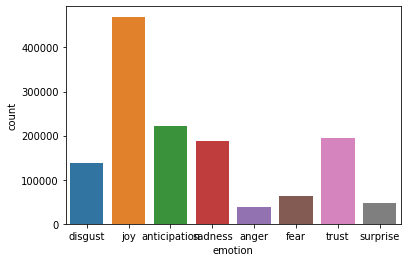

In [18]:
#plot distribution
sns.countplot(train_df['emotion'])

Found that the data is quite imbalance, the most emotion is joy, and for anger/fear/surpise are few data of that classes

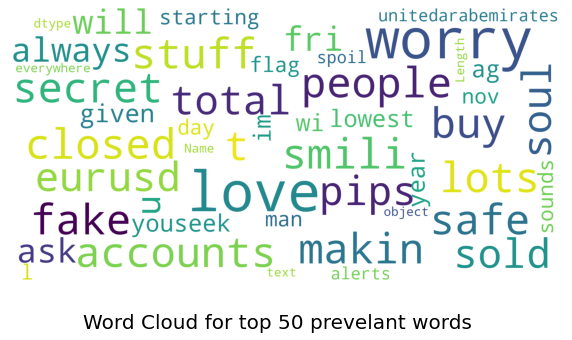

In [11]:
#plot word cloud
from wordcloud import WordCloud, STOPWORDS

word_cloud = WordCloud(
                    background_color='white',
                    stopwords=set(STOPWORDS),
                    max_words=50,
                    max_font_size=40,
                    scale=5,
                    random_state=1).generate(str(train_df['text']))
fig = plt.figure(1, figsize=(10,10))
plt.axis('off')
fig.suptitle('Word Cloud for top 50 prevelant words', fontsize=20)
fig.subplots_adjust(top=2.3)
plt.imshow(word_cloud)
plt.show()

---
# 2. Feature engineering

## 2.1 Using Bag of Words (CountVectorizer)

In [33]:
#bag of word
from sklearn.feature_extraction.text import CountVectorizer

In [34]:
# build analyzers (bag-of-words)
BOW_vectorizer = CountVectorizer(tokenizer=nltk.word_tokenize) #, stop_words = "english") 

In [35]:
# 1. Learn a vocabulary dictionary of all tokens in the raw documents.
BOW_vectorizer.fit(train_df['text'])
BOW_vectorizer.fit(test_df['text'])

# 2. Transform documents to document-term matrix.
X_train = BOW_vectorizer.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_vectorizer.transform(test_df['text'])
y_test = test_df['emotion']

/Users/sand/opt/anaconda3/envs/myenv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


I found that without using stop_words making high accuracy than using it. And I have tried other tokenizeries.

## 2.2 Using TF-IDF vectorizer

I found that BOW (countvectorizer got high accuracy more than IF_IDF), and did not set the limit of maximum features to using only top keyword, getting higher accuracy too.

In [5]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# build analyzers
tfidf = TfidfVectorizer(tokenizer=nltk.word_tokenize) #, stop_words = "english")

# apply analyzer to training data
tfidf.fit(train_df['text'])
tfidf.fit(test_df['text'])

X_train = tfidf.transform(train_df['text'])
y_train = train_df['emotion']

X_test = tfidf.transform(test_df['text'])
y_test = test_df['emotion']

/Users/sand/opt/anaconda3/envs/myenv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


---
# 3. Model
## 3.0 Split the data to test & train

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
#train 80%, test 20%
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, random_state=2021, train_size=0.8)

## 3.1 Naive Bayes
Naive Bayes classifiers are a family of simple "probabilistic classifiers". Naïve Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features/predictors) in a learning problem.

In [208]:
#import
from sklearn.naive_bayes import MultinomialNB

#fit model
navie = MultinomialNB()
navie.fit(X_train1, y_train1)

#accuracy
print('Accuracy of Naive Bayes classifier on training set: {:.2f}'
     .format(navie.score(X_train1, y_train1)))
print('Accuracy of Naive Bayes classifier on test set: {:.2f}'
     .format(navie.score(X_test1, y_test1)))

Accuracy of Naive Bayes classifier on training set: 0.54
Accuracy of Naive Bayes classifier on test set: 0.50


In [231]:
## predict for plot
y_train_pred1 = navie.predict(X_train1)
y_test_pred1 = navie.predict(X_test1)

In [209]:
## predict for submit
y_train_pred = navie.predict(X_train)
y_test_pred = navie.predict(X_test)

## so we get the pred result
y_test_pred[:10]

array(['joy', 'joy', 'joy', 'joy', 'anticipation', 'joy', 'joy',
       'disgust', 'disgust', 'joy'], dtype='<U12')

In [210]:
test_df['emotion']=y_test_pred

In [211]:
#see the predicted result of each emotion
test_df['emotion'].value_counts()

joy             168254
sadness          85962
disgust          59870
anticipation     52989
trust            30324
fear              8966
anger             2913
surprise          2694
Name: emotion, dtype: int64

In [212]:
#check
test_df

,id,emotion,text
1222526,0x359f62,joy,when you come to me needing it is my pleasure ...
1207781,0x241e5e,joy,hey our class exploded soda and mentos toda...
764612,0x235da7,joy,if only my dreams could come true all i want i...
1748715,0x2d0d99,joy,and yet again my family friends never fail to...
926038,0x275a12,anticipation,i'm so worthlessdamagedunableunlovabledeliver ...
...,...,...,...
1729610,0x22b214,fear,exactly right? i think my husband and therapi...
329349,0x1e573d,sadness,it's insane how even when i try to be late to ...
1711925,0x1f388f,joy,i have found a new love for writing blogger wr...
1460648,0x2f8af6,joy,i am fixing to fall asleep from this turkey an...


In [204]:
#export the result to submit
test_df[['id','emotion']].to_csv('predict/result_naive_td_stop.csv')

## 3.2 Decision Trees
Using scikit-learn ```DecisionTreeClassifier``` performs word frequency and uses these as features to train a model.
Decision tree classifier (Pang-Ning et al., 2006) creates the classification model by building a decision tree. Each node in the tree specifies a test on an attribute, each branch descending from that node corresponds to one of the possible values for that attribute.

In [28]:
from sklearn.tree import DecisionTreeClassifier

## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=0)

## training!
DT_model = DT_model.fit(X_train1, y_train1)

In [29]:
#accuracy
print('Accuracy of Decision Tress classifier on training set: {:.2f}'
     .format(DT_model.score(X_train1, y_train1)))
print('Accuracy of Decision Tress on test set: {:.2f}'
     .format(DT_model.score(X_test1, y_test1)))

Accuracy of Decision Tress classifier on training set: 1.00
Accuracy of Decision Tress on test set: 0.40


## 3.3 Logistic Regression

Logistic regression is a classification algorithm, used when the value of the target variable is categorical in nature. Logistic regression is most commonly used when the data in question has binary output, so when it belongs to one class or another, or is either a 0 or 1.

In [206]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(X_train1, y_train1)

#accuracy
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(lr.score(X_train1, y_train1)))
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'
     .format(lr.score(X_test1, y_test1)))

/Users/sand/opt/anaconda3/envs/myenv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy of Logistic Regression classifier on training set: 0.52
Accuracy of Logistic Regression classifier on test set: 0.51


In [7]:
## predict!
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

## so we get the pred result
y_test_pred[:10]

array(['joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'disgust',
       'sadness', 'joy'], dtype=object)

In [8]:
test_df['emotion']=y_test_pred

In [9]:
#export to submit
test_df[['id','emotion']].to_csv('predict/result_lr_if.csv')

## 3.4 AdaBoost Classifier
An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

In [36]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier().fit(X_train1, y_train1)

#accuracy
print('Accuracy of AdaBoost classifier on training set: {:.2f}'
     .format(abc.score(X_train1, y_train1)))
print('Accuracy of AdaBoost classifier on test set: {:.2f}'
     .format(abc.score(X_test1, y_test1)))

Accuracy of AdaBoost classifier on training set: 0.40
Accuracy of AdaBoost classifier on test set: 0.40


## 3.5 Fast text
FastText is an open-source, free, lightweight library that allows users to learn text representations and text classifiers. It is a library for efficient learning of word representations and sentence classification.

In [6]:
#convert data as fastext requires
train_df['forfast']=train_df['text']+'__label__'+train_df['emotion']

In [7]:
train_df['forfast'].to_csv('forfast.txt')

In [8]:
#check
train_df['forfast']

1518109     people makin fake accounts of your stuff i me...
1173035    do not worry your secret is safe with me smili...
1139767    closed buy  lots eurusd  for  pips total for t...
1481568                he has sold his soul __label__disgust
91331      always do what you love and love what u do fri...
                                 ...                        
900153     ask and it will be given to youseek and you wi...
618818     i was at my lowest i ever been about a year ag...
1536443     im starting to worry because the man sounds l...
1538605         flag day nov  unitedarabemirates__label__joy
1706510                spoil alerts everywhere __label__fear
Name: forfast, Length: 1360332, dtype: object

### Define the parameter for the training phase
- lr : learning rate of the training
- epoch : how many times the training will go over the data
- wordNgrams : contiguous sequence of max n words from a given sample of text
- dim : dimension of the word vector

In [164]:
hyper_params = {"lr": 0.01,
                "epoch": 14,
                "wordNgrams": 1,
                "dim": 20,
                "verbose": 1
               }

In [165]:
import fasttext
#train model
model = fasttext.train_supervised('forfast.txt',**hyper_params)
print("Model trained with the hyperparameter \n {}".format(hyper_params))

Model trained with the hyperparameter 
 {'lr': 0.02, 'epoch': 14, 'wordNgrams': 2, 'dim': 20, 'verbose': 1}


In [166]:
# Get model accuracy
result = model.test('forfast.txt')
print("Result : ", result)

Result :  (604213, 0.9569357163781647, 0.9569357163781647)


In [167]:
#check label
print(model.labels)

['__label__joy', '__label__sadness', '__label__anticipation', '__label__trust', '__label__disgust', '__label__fear', '__label__anger', '__label__surprise']


In [168]:
test_df['text'].to_csv("test.txt")

In [169]:
#predict
model.predict("test.txt")
y_test_pred = model.predict("test.txt")
test_df['y_test_pred'] = test_df['text'].apply(lambda x: model.predict(x))

In [170]:
#check the result
test_df

,id,emotion,text,y_test_pred
1222526,0x359f62,joy,when you come to me needing it is my pleasure ...,"((__label__joy,), [0.7525877356529236])"
1207781,0x241e5e,joy,hey our class exploded soda and mentos toda...,"((__label__joy,), [0.5137386322021484])"
764612,0x235da7,joy,if only my dreams could come true all i want i...,"((__label__anticipation,), [0.6434664726257324])"
1748715,0x2d0d99,joy,and yet again my family friends never fail to...,"((__label__joy,), [0.7909117341041565])"
926038,0x275a12,anticipation,i'm so worthlessdamagedunableunlovabledeliver ...,"((__label__joy,), [0.7787424921989441])"
...,...,...,...,...
1729610,0x22b214,sadness,exactly right? i think my husband and therapi...,"((__label__disgust,), [0.3075503706932068])"
329349,0x1e573d,joy,it's insane how even when i try to be late to ...,"((__label__sadness,), [0.624885082244873])"
1711925,0x1f388f,joy,i have found a new love for writing blogger wr...,"((__label__joy,), [0.8282995223999023])"
1460648,0x2f8af6,joy,i am fixing to fall asleep from this turkey an...,"((__label__joy,), [0.8406416773796082])"


In [171]:
#export to submit
test_df[['id','y_test_pred']].to_csv("predict/enough_set16.csv")

---
#  4.Result Evaluation

## Naive Bayes

In [232]:
## precision, recall, f1-score
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test1, y_pred=y_test_pred1))

              precision    recall  f1-score   support

       anger       0.59      0.10      0.18      7559
anticipation       0.52      0.50      0.51     44455
     disgust       0.42      0.42      0.42     27378
        fear       0.63      0.30      0.41     12460
         joy       0.54      0.73      0.62     93946
     sadness       0.41      0.48      0.45     37553
    surprise       0.61      0.13      0.21      9673
       trust       0.50      0.27      0.35     39043

    accuracy                           0.50    272067
   macro avg       0.53      0.37      0.39    272067
weighted avg       0.51      0.50      0.48    272067



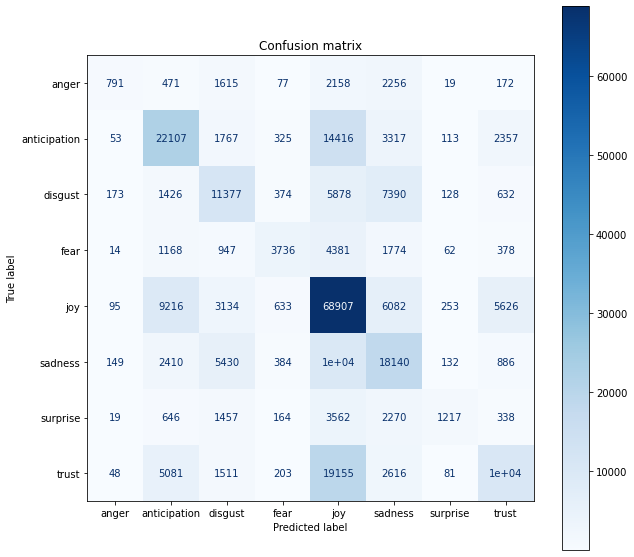

In [237]:
from sklearn.metrics import plot_confusion_matrix

# plot your confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(navie, X_test1, y_test1, cmap=plt.cm.Blues,ax=ax) 
plt.title('Confusion matrix')
plt.show()

From the confusion Matrix, the Joy was predicted which is highest correctness. For the confusion, The true: trust and predicted: joy is kind of confusing. There are 19,155 which is a true label as trust, but it is predicted to joy. There is also confusion on joy and anticipation, there are are 14,416 which is a true label as anticipation, but it is predicted to joy. 

---
# 5. Conclusion

Final Result on Kaggle that I have summited
1. BOW + Decision Tree (limit max feature as 500) 0.23971
2. TFIDF + Naive Bayes 0.41400
4. BOW + Logitistic Regression 0.43464
6. BOW + Naive Bayes 0.44512
7. Fasttext 0.44968
8. Fasttext (tuning parameter of the model) 0.46415

What have I learned? First, for preprocessing data which is very important part, I need to understand the data for cleaning it, which is the tweet text, so it might have a lot of hashtags, HTML tags, emojis. And, need to understand English text like stop words. Second, on tokenization, I have tried many ways e.g. limit maximum features, keep stop words/ without stop words -> Found that should not limit the maximum features and keep stop words (on social text, stop words might important) Third, modeling, Try and research many models, try to train and see the result.